# Introduction to Photoluminesence

In this tutotial I will go over the basics of conducting a photoluminesence (PL) experiment in our lab.

After this tutorial you should be able to:
* Collect PL data using Light Field
* Plot PL spectra in python.
* Analyze that data to determine useful quantitative metrics such as integrated peak area, the wavelength of maximum intensity, and the average PL intenstiy

Photoluminescence tells you what light is emitted by a solar cell. The wavelength (and thus energy) of the light emitted corresponds to the size of the band gap as a result of radiative recombination. Photoluminescence data informs us about the different optical and physical qualities of a material, particularly the level of radiative recombination.

# Collecting Photoluminesence Data
NOTE: THIS DOCUMENT IS MEANT TO SERVE AS A REMINDER AND GUIDE FOR DOING DATA COLLECTION AND ANALYSIS, BUT DOES NOT REPLACE A FORMAL TRAINING. FAILURE TO USE THE EXPERIMANTAL SETUP CORRECTLY CAN RESULT IN INJURING YOUSELF AND DAMAGING THE VERY EXPENSIVE CCD CAMERA. 

Before taking PL data be sure to have done laser safety and reviewed the laser SOP in our lab. To set up the experiment you will have to align the experimental setup such that the laser is hitting your sample of interest, and the emitted light (the PL) is being directed into the spectrapro with maximum efficiency. A typical experimental layout for this experiment will be: 

![Experimental Setup](data/IMG_0085.jpg)

Once you have the hardware for the experiment setup up, you need to turn to the software. Lightfield is a powerful piece of software used to control the spectrograph and camera. Depending upon your experiment there are many variables you can tune to improve data collection. To get started though you should focus on the following settings:

![Software Setup](data/IMG_0086.jpg)

If you open lightfield and load "PL Standard" you will be able to access these settings directly. The most basic experiment we can run is capturing a single spectra using the above settings. Hitting the "Aquire" button will save the PL data that we can use for analysis. 

# Plotting PL Spectra
Now that we know how to collect PL data, we can use our python tools to import and analyze that data. We will begin by importing the required packages and defining a few functions that will be useful in our data analysis.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def find_nearest(array, value):
    #array is a 1D vector 
    #value is the specific value for which want the index
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def trim_data(x, data, limit1, limit2):
    #x is a 1D array of values (e.g. wavelength)
    #data is a 1D array of intensities
    #limit1 and limit2 represent the range ou'd like to trim your data to 
    set1 = find_nearest(x,limit1)
    set2 = find_nearest(x,limit2)
    return x[set1:set2], data[set1:set2]

def back_subtract(x, data, length):
    #x is a 1D array of wavelengths
    #data is an array of intensities
    #length is the number of values on the edges of the data you want to use to create a linear background 
    x_linear = np.hstack((x[0:length], x[-length:-1])) #I'm taking the starting and ending values
    data_linear = np.hstack((data[0:length], data[-length:-1])) #We'll use these to fit a straight line
    slope, intercept = np.polyfit(x_linear, data_linear, 1) #Do linear fit
    back = slope*x+intercept 
    data_correct=(data-back)
    return data_correct

def gaussian(x, a, b, c): 
    return a*np.exp(-(x - b)**2/(2*c**2))

We can now import some PL data. We'll begin by looking at the emission from a MAPbI3 perovskite sample by importing the data and plotting it.

Text(0, 0.5, 'Intensity [counts]')

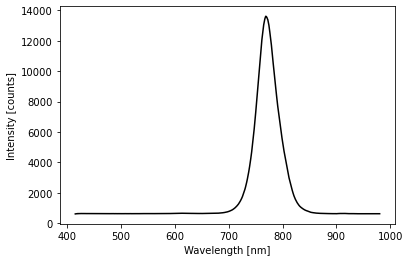

In [57]:
#   Import Data
file_name = 'data/MAPbI3_PL.csv' #the data we will be importing 
PL = pd.read_csv(file_name, index_col=None, header=0) #read in file as a pandas datafram

fig1, ax1 = plt.subplots() #we'll make a plot to see what the data looks like
ax1.plot(PL["Wavelength"], PL["Intensity"], 'k-') #using pandas notation we can plot wavelength vs. intensity 
ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('Intensity [counts]')

Similar to the XRD analysis, we can clean up the raw data by trimming the data to focus on our object of interest and removing the background. 

Text(0, 0.5, 'Intensity [a.u.]')

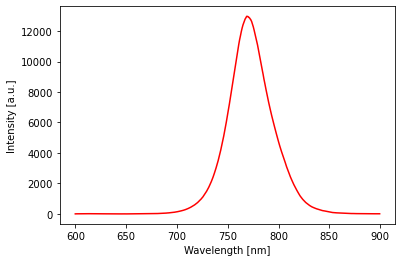

In [58]:
#    Cleaning Up the Data

wave = np.array(PL["Wavelength"]) #we'll convert the data from a pandas datafram to a numpy array for more facile (for me :)) analysis
PL_I3 = np.array(PL["Intensity"])

wave_sub, PL_sub = trim_data(wave, PL_I3, 600,900) #trim the data to only look at the data between 600 and 900 nm. It is often worthwhile to cut out wavelenghts below 500 nm since we often get counts from our laser in that region
PL_back = back_subtract(wave_sub,PL_sub,20) #remove a linear background from the PL data

fig2, ax2 = plt.subplots() #we'll make a plot to see what the data looks like
ax2.plot(wave_sub, PL_back, 'r-') #plot wavelength vs. intensity 
ax2.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('Intensity [a.u.]') #if I've ammended the data in anyway I will generally change the axis from counts to arbitrary unitys (a.u.)


# Analyzing PL Spectra
As you work in the lab you will learn that PL can tell us a lot about our sample. Often we're interested in a wavelength that describes the PL. I'm going to describe three different ways in finding a charateristic PL wavelength, and while they may initially feel very similar you'll find they have important differences in what they describe about your sample.

## Wavelength of Max Intensity
Perhaps the simplest analysis is to determine the wavelength at which the PL is the largest. 

## Average PL Wavelength
Instead of just the maximum we can calculate an PL intensity weighted average wavelength. This can be particularly helpful if our PL peak is not symmetrical. 

## Peak Center
If we can fit our data to a gaussian peak, the center of the peak can nicely describe the emission of our sample

We'll do each of these for this data set.

Max Wave: 768.7800569212761 nm; Average Wave: 772.7001073216974 nm; Fit Wave: 771.4514162031365 nm


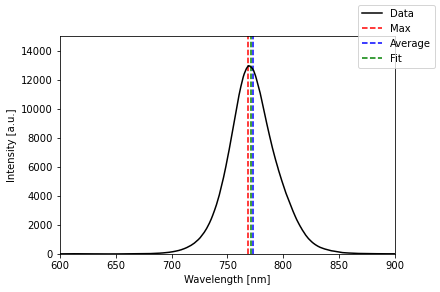

In [59]:
#   Find wavelength of maximum intensity 

def max_wave(wave,intensity):
    # wave is a 1D array of wavelengths
    # intensity is a 1D array of intensities
    max_int = np.max(intensity) # find the max intesnity
    return wave[find_nearest(intensity,max_int)] # find the index of the max intensity and the corresponding wavelength

max = max_wave(wave_sub,PL_back) #use our new definition

#   Find wavelength of average PL intensity 

def average_PL(wave,intensity):
    # wave is a 1D array of wavelengths
    # intensity is a 1D array of intensities
    scaled_wave = wave*intensity/np.sum(intensity) #scale the wavelength by the intensity of the PL at that given wavelength
    return sum(scaled_wave) #the average wavelength is the sum of the scaled_wave 

average = average_PL(wave_sub,PL_back) 

#   Fit the PL curve and report it's center wavelength
guess = [12000, 760, 10] #As usual we'll give a best guess for the fit parameters that define our peak in the form [max intesnity, center, FWHM]  
peak, error = curve_fit(gaussian,wave_sub,PL_back, p0 = guess) #Do the curve fitting using the least squares method
fit = peak[1] #Pull out the fitted peak center from the best fit

print('Max Wave:', max, 'nm;', 'Average Wave:', average, 'nm;', 'Fit Wave:', fit, 'nm') #print the values we get from our analysis

fig3, ax3 = plt.subplots() #Make a plot to compare the various methods of analysis for finding a characteristic wavelength
ax3.plot(wave_sub, PL_back, 'k-', label = 'Data') #using pandas notation we can plot wavelength vs. intensity 
ax3.vlines(max, 0, 15000, colors='red', linestyles = 'dashed', label='Max') #mark maximum wavelength with vertical line
ax3.vlines(average, 0, 15000, colors='blue', linestyles = 'dashed', label='Average') #mark maximum wavelength with vertical line
ax3.vlines(fit, 0, 15000, colors='green', linestyles = 'dashed', label='Fit') #mark maximum wavelength with vertical line
ax3.set_ylim(0,15000) # Set limits for plot
ax3.set_xlim(600,900) # Set limits for plot
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('Intensity [a.u.]')
fig3.legend(loc="upper right")


# Exercise 1: PL of MAPbI1.5Br1.5
Now that you've seen the process once, attempt to do the same process but with a new piece of data - the photoluminesence of a mixed halide sample. Make a plot similar to the above figure, making note of differences in characteristic wavelength for this sample. Be prepared to have a conversation on what the source of these differences are, and the signficance of characteristic wavelength for thsi sample.